<a href="https://colab.research.google.com/github/truthdead/PastaClassifier/blob/main/Pasta_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> <b> Know Your Pasta - A pasta classifier + Recipe Guide </b> </center><h1>

- First let's define our methodology for this project. I'd like to experiment with the Drivetrain Approach by Jeremy Howard et al. I haven't exactly followed this approach before, but I prefer the iterative way of development and also trust Jeremy and his course - FastAI.

Target is to have a complete product even at the end of the first iteration.

- Steps :

1. Objective  - Do build an app that make use of a model which can predict the type of pasta from a picture of a pasta-based meal, and suggest some of the best dishes to prepare with it. The latter will include a history of the pasta type, and a recipe. Target consumers are pasta fans around the world.

2. Levers - What actions you can take?/What inputs you can control? - asking use to upload an image in order to make a prediction. Suggest a recipe based on the prediction.

   (*Side Note- Now I have to admit that I myself don't totally understand 
   what this step exactly means, but hey, everything is a process, and let's
   try to understand it better with time.* )



3. Data - We can start with publicly available data. I'm starting with downloading Bing images available via its API.

4. Building a model - We initially use search engine generated images. Then we can use user uploaded data with theit explicit consent. Will use Deep Neural network as an algorithm and Pytorch and FastAI as Python frameworks to build our model. 




### <b> Gathering Data </b>

Now that we have a clear objective, let's gather some data. I'm using the Bing search engine to download my images related to pasta. 

I've done some research behind the scenes about pasta and its history, but I'm not going to bore you with all the details in this first iteration. We all know it's widely regarded as an Italian dish. But its origins date back to 14th century China and Greece. There are over 600 varieties of pasta, but all of them fall under one of the following category ::
1. Strand 
2. Ribbon
3. Tubular
4. Micro
5. Unique-shaped
6. Stuffed

<img src= "https://drive.google.com/uc?export=view&id=1oVxHGisrY-BphIIhabhS9uiW40OyvKF-" alt='pasta types according to shape' width='700' height='500'>




Now I'm gonna leave out stuffed pasta, coz it's identification may well be out of the scope for my model. So I'm concentrating on 26 most common and popular pasta varieties that belong to one of the above categories. I believe they are the most important ones in-terms of production and consumption. But there will always be room for expansion and updates.  

So here are the varieties I'm going to gather input data on (They will also be the labels for my model) ::

Let's download the data then. We need to import the relevant fastai components first. 

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [ ]:
#importing fastai.vision and fastbook
from fastbook import *
from fastai.vision import *


In [ ]:
#all pasta types in a list:

pasta_types = ('pappardelle', 'conchiglie', 'gnocchi', 
'fusilli', 'spaghetti', 'vermicelli', 'capellini', 
'rotini', 'pici', 'orecchiette', 
'bucatini', 'penne', 'cannelloni', 'macaroni',
'ziti', 'ravioli', 'linguine', 'fettuccine',
'lasagne', 'trofie', 'mafaldine', 'rigatoni',
'farfalle', 'stelline', 'orzo', 'ditalini')




In [ ]:
pasta_types

('pappardelle',
 'conchiglie',
 'gnocchi',
 'fusilli',
 'spaghetti',
 'vermicelli',
 'capellini',
 'rotini',
 'pici',
 'orecchiette',
 'bucatini',
 'penne',
 'cannelloni',
 'macaroni',
 'ziti',
 'ravioli',
 'linguine',
 'fettuccine',
 'lasagne',
 'trofie',
 'mafaldine',
 'rigatoni',
 'farfalle',
 'stelline',
 'orzo',
 'ditalini')

Great, so the list is all unique elements and there are 26 of them. Therefore, there are 26 labels for our data to train on. 

In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY', '34c37e72546742de95673b651630a4aa')

In [ ]:
#creating a path object for the common folder
path = Path('Pastas')

In [ ]:
if not path.exists():
    path.mkdir()
    for o in pasta_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, o)
        download_images(dest, urls=results.attrgot('contentUrl'))

structure of download_url function is as follows ::

Signature: download_url(url, dest=None, timeout=None, show_progress=True)

Docstring: Download `url` to `dest` and show progress

File:      /usr/local/lib/python3.7/dist-packages/fastdownload/core.py

Type:      function

In [ ]:
path

Path('Pastas')

In [ ]:
fns = get_image_files(path)
fns

(#3761) [Path('Pastas/trofie/00000043.jpg'),Path('Pastas/trofie/00000103.jpg'),Path('Pastas/trofie/00000017.jpg'),Path('Pastas/trofie/00000095.jpg'),Path('Pastas/trofie/00000057.jpg'),Path('Pastas/trofie/00000136.jpg'),Path('Pastas/trofie/00000078.jpg'),Path('Pastas/trofie/00000143.jpg'),Path('Pastas/trofie/00000064.jpg'),Path('Pastas/trofie/00000079.jpg')...]

In [ ]:
failed = verify_images(fns)
failed

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


(#22) [Path('Pastas/trofie/00000026.jpg'),Path('Pastas/cannelloni/00000015.jpg'),Path('Pastas/spaghetti/00000105.jpg'),Path('Pastas/spaghetti/00000133.jpg'),Path('Pastas/lasagne/00000094.jpg'),Path('Pastas/lasagne/00000148.jpg'),Path('Pastas/bucatini/00000136.png'),Path('Pastas/fusilli/00000028.jpg'),Path('Pastas/linguine/00000051.jpg'),Path('Pastas/macaroni/00000126.png')...]

In [ ]:
failed.map(Path.unlink)

(#22) [None,None,None,None,None,None,None,None,None,None...]

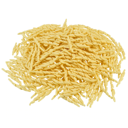

In [ ]:
im = Image.open(fns[0])
im.to_thumb(256,128)

In [ ]:
pastas = DataBlock(
    blocks= (ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=128, min_scale=.75)
)

In [ ]:
pastas.summary(path)

Setting-up type transforms pipelines
Found 3753 items
2 datasets of sizes 3003,750
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      Pastas/stelline pasta/00000010.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=800x800
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      Pastas/stelline pasta/00000010.jpg
    applying parent_label gives
      stelline pasta
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(22)

Final sample: (PILImage mode=RGB size=800x800, TensorCategory(22))


Found 3753 items
2 datasets of sizes 3003,750
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: Resize -- {'size

In [ ]:
doc(pastas.dataloaders)

In [ ]:
pastaloaders = pastas.dataloaders(path)

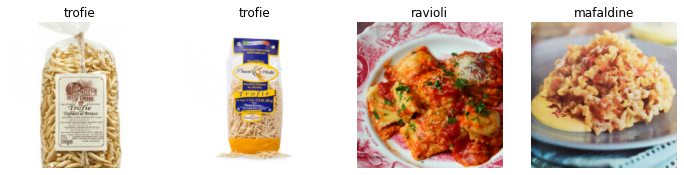

In [ ]:
pastaloaders.valid.show_batch(max_n=4, nrows=1)

In [ ]:
pasta_learner = cnn_learner(pastaloaders, resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


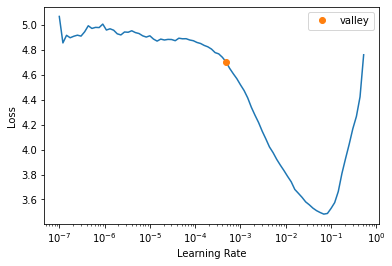

In [ ]:
valley = pasta_learner.lr_find()

In [ ]:
valley

SuggestedLRs(valley=0.0004786300996784121)

In [ ]:
#fitting one cycle with the tail frozen (we are training just the head)
pasta_learner.fit_one_cycle(5, 0.0005)

epoch,train_loss,valid_loss,error_rate,time
0,3.726170,1.842235,0.551539,04:14
1,2.427501,1.415973,0.437751,04:13
2,1.766698,1.278551,0.402945,04:07
3,1.374364,1.187473,0.370817,04:12
4,1.170575,1.186568,0.366801,04:18


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes sh

In [ ]:
from fastai.vision.widgets import *

In [ ]:
cleaner = ImageClassifierCleaner(pasta_learner)
cleaner

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [ ]:
#unfreezing
pasta_learner.unfreeze()

In [ ]:
pasta_learner.lr_find()

In [ ]:
pasta_learner.fit_one_cycle(10, lr_max=slice())

How to save the images in your drive :
https://forums.fast.ai/t/01-intro-google-colab-path-where-are-downloaded-files-are-saved/77679/3

### Improving performance using Leslie Smith's Learning Rate method

- Learning rate finder of fastai is based on Leslie Smith's 2015 paper on 'Cyclical Learning Rates'. 

- Here, we use start with a very small learning rate with which we cant overshoot, and train one mini-batch. Then we gradually increase the learning rate and train a mini-batch with each of the rates. Finally we plot the loss against the learning rate. We can then decide on the optimal learning rate to train our data. 
Fastai suggests we choose either of these points :
  - one tenth of the minimal learning rate or 
  - the last point of learning rate where the reduction of the loss is the steepest. 

- lr_finder() is the function used to find above points
- then, instead of using fine_tune() above, we are going to use fit_one_cycle()
- What does fit_one_cycle() do?

When we create a model in fastai using a pretrained model, it adds random weights for the last layer and freezes all pretrained layers. When you call fine_tune(), it first trains the last layer for one epoch with others frozen, then unfreezes the other ones and trains all layers for number of epochs we asked for. 

But fit_one_cycle() allows for more flexlible training. The suggested path with it is like this:
- first we find the optimal lr with lr_finder as above.
- then we call fit_one_cycle() with lr obtained via first step --> this trains the last layer while others stay frozen. Training starts with a low rate and increases for the first half and decreases for the second.
- Then we unfreeze (learn.unfreeze())
- we again call lr_finder, this time the plot will show a graph where loss gets worsen after some time. Now we pick the lr WELL before it worsens.
- then we call fit_one_cycle() for a number of epochs we desire.
- In this final step, we use `slice()` function of python to pass a variable learning rate to the lr_max argument inside `fit_one_cycle()` this allow us to pass two learning rates : first will be the learning rate the initial layers are trained with, this is a low one (can you tell why?); second will be the lr the last layer trains with. All other layers will train with lrs multiplicatively equidistant from each other. This idea by fastai is based on findings of Jason Yosinski, who showed in 2014, that with transfer learning, different layers should train with different lrs for optimal performance.  

In [ ]:
#lets code now:

pasta_learner2 = cnn_learner(pastaloaders, resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Ok, I'm getting the above error because the `lr_find` changed a bit recently. I got the answer from fastai forums, here's the link (answer by dhruv.metha) ▶ https://forums.fast.ai/t/error-in-lr-find/89968/2 

And also, this article my Zach Mueller, who was behind this lr_find update, explains how 'valley' is a better choice for lr. so let's use that. I'll train the model again from scratch. this time, it's just learn.
https://www.novetta.com/2021/03/learning-rate/

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  

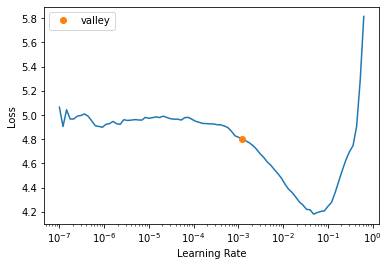

In [ ]:
valley1 = pasta_learner2.lr_find()

In [ ]:
valley1

SuggestedLRs(valley=0.0012022644514217973)

In [ ]:
path

Path('Pastas')

In [ ]:
#from fastai.callback.schedule import fit_one_cycle
pasta_learner2.fit_one_cycle??

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pasta_learner2.fit_one_cycle(3, lr_max=2e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.719564,1.804895,0.506684,03:14
1,1.634121,1.666900,0.485294,03:13
2,1.442672,1.620405,0.481283,03:13


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes sh

In [ ]:
pasta_learner2.unfreeze()

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  

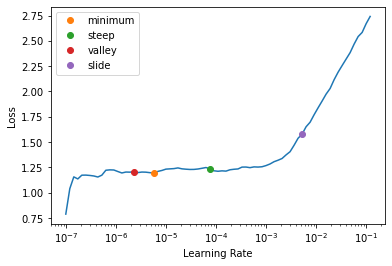

In [ ]:
min, steepest, valley2, slide1 = pasta_learner2.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
from fastai.vision.widgets import *

In [ ]:
cleaner = ImageClassifierCleaner(pasta_learner2)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [ ]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)